## Dummy Investing 101: Learn from the ‘Best’ or the ‘Bets’?
#### Authors: Chengxiaoyuan Wang, Jiahao Wang, Sihao Wang, Peiyao Wu, Chenyuan Zheng

### Part I --- 13F Scraper + Backtest

#### Package Set-up for 13F scraper and backtest

In [17]:
#Import libraries for scraper
import re
import time
from bs4 import BeautifulSoup
import requests
import os
import random as random

from urllib.request import urlretrieve
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.keys import Keys

In [3]:
#Import libraries for ticker finder and backtest
import pandas as pd
from fuzzywuzzy import fuzz
import yfinance as yf  
import matplotlib.pyplot as plt
import numpy as np


#### 13F Scaper

In [5]:
#Retrieve 13Fs from sec.gov and process data for portfolio construction
def sec13f_scraper(names):
    pageLink = 'https://www.sec.gov/edgar/search/#'
    path = "chromedriver"
    browser = webdriver.Chrome(path)
    browser.get(pageLink)
    # open browser
    browser.find_element(By.XPATH,'//a[@class="text-white"]').click()
    time.sleep(1)
    #Set up HTTP Header User Agent and Proxies Pool to bypass SEC's anti-scraping system
    header = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
             "X-Requested-With": "XMLHttpRequest"}
    
    #Import proxies list and adjust it for our usage
    proxy=open('http_proxies.txt','r')
    proxyt=proxy.read()
    proxy_list=proxyt.split("\n")
    for i in range(0,99):
        proxy_list[i]='http://'+proxy_list[i]
    
    #Initiate inputs for SEC EDGAR advanced search bar
    form='13F HR'
    startdate = '2016-01-01'
    search_doc = '//input[@class="company form-control border-onfocus hide-on-short-form text-black"]'
    search_name = "//input[@class='entity form-control border-onfocus text-black hide-on-short-form']"
    date_from = '//input[@class="form-control border-onfocus hide-on-short-form text-black hasDatepicker"]'
    
    #Initiate row counter
    row = 0
    
    #Initiate empty lists for issuer names
    Q1_2016=[]
    Q2_2016=[]
    Q3_2016=[]
    Q4_2016=[]
    Q1_2018=[]
    Q2_2018=[]
    Q3_2018=[]
    Q4_2018=[]
    Q1_2020=[]
    Q2_2020=[]
    Q3_2020=[]
    Q4_2020=[]
    
    #Scraping starts
    for n in names:
        row = 0
        #Input values: name, document, date
        #Clear previous input in names
        for i in range(0,50):
            browser.find_element(By.XPATH,search_name).send_keys(Keys.BACKSPACE)
        time.sleep(random.randint(1,3))
        #Enter names
        browser.find_element(By.XPATH,search_name).send_keys(n)
        time.sleep(random.randint(2,4))
        #Clear previous input in doc type
        for i in range(0,8):
            browser.find_element(By.XPATH,search_doc).send_keys(Keys.BACKSPACE)
        time.sleep(random.randint(3,8))
        #Enter doc type
        browser.find_element(By.XPATH,search_doc).send_keys(form)
        time.sleep(random.randint(2,4))
        #Clear previous input in date
        for i in range(0,11):
            browser.find_element(By.XPATH,date_from).send_keys(Keys.BACKSPACE)
        time.sleep(random.randint(3,6))
        #Enter date and return result
        browser.find_element(By.XPATH,date_from).send_keys(startdate)
        browser.find_element(By.XPATH,date_from).send_keys(Keys.RETURN)
        time.sleep(random.randint(1,3))
        browser.find_element(By.XPATH,'//button[@id="search"]').click()
        time.sleep(random.randint(7,10))

        #Collect all related information about the documents(date, entity name)
        page_source = browser.page_source
        soup = BeautifulSoup(page_source, 'lxml')
        filling=soup.find_all('td',class_='filed')
        reporting = soup.find_all('td',class_='enddate')
        
        #Initiate empty lists to store filling information
        file_info=[]
        filed=[]
        orgname=[]
        report_for=[]
        
        #Store filed date, report for (date), and name of the fund
        for x in filling:
            f = x.text
            filed.append(f)
        for i in orgname:
            o = i.text
            orgname.append(o)
        for s in reporting:
            r = s.text
            report_for.append(r)
        file_info = [[i , j ]
           for i, j in zip(filed, report_for)]
        for x in file_info:
            x.append(n)

        #Loop thru each 13F link
        docs= browser.find_elements(By.XPATH,'//a[@href="#xslForm13F_X01/primary_doc.xml"]')
        
        for x in docs:
            time.sleep(random.randint(3,6))
            x.click()
            
            #Current location: Search page
            page_source = browser.page_source
            soup0 = BeautifulSoup(page_source, 'lxml')
            url0=soup0.find("a",id="open-submission").get("href")
            
            #Current location: Filing Detail page
            time.sleep(random.randint(2,6))
            
            #Use randomly selected proxy to send request and grab the urls leading to the individual fund's info table page
            try:
                proxies = {'http': proxy_list[random.randint(0,98)]}
                r1 = requests.get(url0, headers=header,proxies=proxies,timeout=5)
                soup1 = BeautifulSoup(r1.content, 'lxml')
                url1="https://www.sec.gov/"+soup1.find("table",class_="tableFile").findAll("tr")[4].findAll("td")[2].find("a").get("href")
            except:
                #Freeze in case the randomly chosen proxy had already been blacklisted by SEC and resulted in 10-min temporary block
                print('2nd attempt,wait for 10 min')
                time.sleep(620)
                try:
                    proxies = {'http': proxy_list[random.randint(0,98)]}
                    r1 = requests.get(url0, headers=header,proxies=proxies,timeout=5)
                    soup1 = BeautifulSoup(r1.content, 'lxml')
                    url1="https://www.sec.gov/"+soup1.find("table",class_="tableFile").findAll("tr")[4].findAll("td")[2].find("a").get("href")
                except:
                    time.sleep(2)
                    print('3rd attempt')
                    time.sleep(2)
                    try:
                        proxies = {'http': proxy_list[random.randint(0,98)]}
                        r1 = requests.get(url0, headers=header,proxies=proxies,timeout=5)
                        soup1 = BeautifulSoup(r1.content, 'lxml')
                        url1="https://www.sec.gov/"+soup1.find("table",class_="tableFile").findAll("tr")[4].findAll("td")[2].find("a").get("href")
                    except:
                        print('Proxy failure')
           
            #Current location: 13F info table page (XML)
            
            time.sleep(random.randint(2,6))
            try:
                proxies = {'http': proxy_list[random.randint(0,98)]}
                r2 = requests.get(url1, headers=header,proxies=proxies,timeout=5)
                soup2 = BeautifulSoup(r2.content, 'lxml')
            except:
                #Freeze in case the randomly chosen proxy had already been blacklisted by SEC and resulted in 10-min temporary block
                print('2nd attempt,wait for 10 min')
                time.sleep(620)
                try:
                    proxies = {'http': proxy_list[random.randint(0,98)]}
                    r2 = requests.get(url1, headers=header,proxies=proxies,timeout=5)
                    soup2 = BeautifulSoup(r2.content, 'lxml')
                except:
                    time.sleep(2)
                    print('3rd attempt')
                    try:
                        proxies = {'http': proxy_list[random.randint(0,98)]}
                        r2 = requests.get(url1, headers=header,proxies=proxies,timeout=5)
                        soup2 = BeautifulSoup(r2.content, 'lxml')
                    except:
                        print('Proxy failure')
            soup2 = BeautifulSoup(r2.content, 'lxml')
            
            #Scrape the XML page and parse out the wanted data
            nameofissuers=[i.text for i in soup2.findAll("nameofissuer")]
            values=[i.text for i in soup2.findAll("value")]
            
            #Remove commas in the values variables and turn str to int
            values = [int(x.replace(",", "")) for x in values]
            
            #Save "nameofissuer" and "value" into a dataframe
            dict2={"Issuer":nameofissuers,"Value":values}
            df=pd.DataFrame(dict2)
            df1=df.copy()
            
            #Aggregate values for each issuer, sort value, and save the top 3 holdings
            final = df1.groupby(['Issuer'], as_index=False)['Value'].sum()
            final = final.sort_values(by = 'Value', ascending=False )
            final1 = final.head(3)
            


            #Append top 3 holdings in each file of each fund to the corresponding quarter portfolios 
            top3=final1['Issuer'].to_list()
            
            #Tracking the progress
            print(file_info[row][0])
            print(file_info[row][2])
            print(top3)
  
            if file_info[row][0][:4]=='2016':
                if file_info[row][0][6] == '2':
                    Q1_2016.append(top3)
                if file_info[row][0][6] == '5':
                    Q2_2016.append(top3)
                if file_info[row][0][6] == '8':
                    Q3_2016.append(top3)
                if file_info[row][0][6] == '1':
                    Q4_2016.append(top3)

            if file_info[row][0][:4]=='2018':
                if file_info[row][0][6] == '2':
                    Q1_2018.append(top3)
                if file_info[row][0][6] == '5':
                    Q2_2018.append(top3)
                if file_info[row][0][6] == '8':
                    Q3_2018.append(top3)
                if file_info[row][0][6] == '1':
                    Q4_2018.append(top3)

            if file_info[row][0][:4]=='2020':
                if file_info[row][0][6] == '2':
                    Q1_2020.append(top3)
                if file_info[row][0][6] == '5':
                    Q2_2020.append(top3)
                if file_info[row][0][6] == '8':
                    Q3_2020.append(top3)
                if file_info[row][0][6] == '1':
                    Q4_2020.append(top3)

            row+=1  # using this as a row counter, moving down one row for each fund's 13F              
            
            browser.find_element(By.XPATH,'//button[@class="close"]').click()
            
    browser.quit()
    return Q1_2016,Q2_2016, Q3_2016,Q4_2016, Q1_2018, Q2_2018, Q3_2018, Q4_2018,Q1_2020, Q2_2020, Q3_2020, Q4_2020

#### Ticker Matcher

In [ ]:
#Match the company names with their corresponding ticker symbols
def ticker_matcher(Q1_2016,Q2_2016,Q3_2016,Q4_2016,Q1_2018,Q2_2018,Q3_2018,Q4_2018,Q1_2020,Q2_2020,Q3_2020,Q4_2020):   
    
    #Initialize empty lists for storing tickers and constructing portfolios
    Q1_2016_port=[]
    Q2_2016_port=[]
    Q3_2016_port=[]
    Q4_2016_port=[]
    Q1_2018_port=[]
    Q2_2018_port=[]
    Q3_2018_port=[]
    Q4_2018_port=[]
    Q1_2020_port=[]
    Q2_2020_port=[]
    Q3_2020_port=[]
    Q4_2020_port=[]

    #Import ticker dictionary
    t_dict=pd.read_csv('ticker dictionary clean.csv') 
    
    #Run name match to retrieve tickers from the ticker dictionary
    for f in Q1_2016:
        for c in f:
            c1=c.lower()
            c2=c1.split()[0] 

            for d in range(0,len(t_dict['Name'])):
                d1=t_dict['Name'][d]
                d2=d1.split()[0] 
                
                #Check if the first words matches
                if c2==d2:
                    #Check non-exact match score; if greater than 75, then match succeed
                    if fuzz.partial_ratio(c1,d1) >=75:
                        Q1_2016_port.append(t_dict['Symbol'][d])

    for f in Q2_2016:
        for c in f:
            c1=c.lower()
            c2=c1.split()[0] 

            for d in range(0,len(t_dict['Name'])):
                d1=t_dict['Name'][d]
                d2=d1.split()[0] 

                if c2==d2:
                    if fuzz.partial_ratio(c1,d1) >=75:
                        Q2_2016_port.append(t_dict['Symbol'][d])

    for f in Q3_2016:
        for c in f:
            c1=c.lower()
            c2=c1.split()[0] 

            for d in range(0,len(t_dict['Name'])):
                d1=t_dict['Name'][d]
                d2=d1.split()[0] 

                if c2==d2:
                    if fuzz.partial_ratio(c1,d1) >=75:
                        Q3_2016_port.append(t_dict['Symbol'][d])

    for f in Q4_2016:
        for c in f:
            c1=c.lower()
            c2=c1.split()[0] 

            for d in range(0,len(t_dict['Name'])):
                d1=t_dict['Name'][d]
                d2=d1.split()[0] 

                if c2==d2:
                    if fuzz.partial_ratio(c1,d1) >=75:
                        Q4_2016_port.append(t_dict['Symbol'][d])

    for f in Q1_2018:
        for c in f:
            c1=c.lower()
            c2=c1.split()[0] 

            for d in range(0,len(t_dict['Name'])):
                d1=t_dict['Name'][d]
                d2=d1.split()[0] 

                if c2==d2:
                    if fuzz.partial_ratio(c1,d1) >=75:
                        Q1_2018_port.append(t_dict['Symbol'][d])


    for f in Q2_2018:
        for c in f:
            c1=c.lower()
            c2=c1.split()[0] 

            for d in range(0,len(t_dict['Name'])):
                d1=t_dict['Name'][d]
                d2=d1.split()[0] 

                if c2==d2:
                    if fuzz.partial_ratio(c1,d1) >=75:
                        Q2_2018_port.append(t_dict['Symbol'][d])


    for f in Q3_2018:
        for c in f:
            c1=c.lower()
            c2=c1.split()[0] 

            for d in range(0,len(t_dict['Name'])):
                d1=t_dict['Name'][d]
                d2=d1.split()[0] 

                if c2==d2:
                    if fuzz.partial_ratio(c1,d1) >=75:
                        Q3_2018_port.append(t_dict['Symbol'][d])

    for f in Q4_2018:
        for c in f:
            c1=c.lower()
            c2=c1.split()[0] 

            for d in range(0,len(t_dict['Name'])):
                d1=t_dict['Name'][d]
                d2=d1.split()[0] 

                if c2==d2:
                    if fuzz.partial_ratio(c1,d1) >=75:
                        Q4_2018_port.append(t_dict['Symbol'][d])


    for f in Q1_2020:
        for c in f:
            c1=c.lower()
            c2=c1.split()[0] 

            for d in range(0,len(t_dict['Name'])):
                d1=t_dict['Name'][d]
                d2=d1.split()[0] 

                if c2==d2:
                    if fuzz.partial_ratio(c1,d1) >=75:
                        Q1_2020_port.append(t_dict['Symbol'][d])


    for f in Q2_2020:
        for c in f:
            c1=c.lower()
            c2=c1.split()[0] 

            for d in range(0,len(t_dict['Name'])):
                d1=t_dict['Name'][d]
                d2=d1.split()[0] 

                if c2==d2:
                    if fuzz.partial_ratio(c1,d1) >=75:
                        Q2_2020_port.append(t_dict['Symbol'][d])

    for f in Q3_2020:
        for c in f:
            c1=c.lower()
            c2=c1.split()[0]

            for d in range(0,len(t_dict['Name'])):
                d1=t_dict['Name'][d]
                d2=d1.split()[0] 

                if c2==d2:
                    if fuzz.partial_ratio(c1,d1) >=75:
                        Q3_2020_port.append(t_dict['Symbol'][d])

    for f in Q4_2020:
        for c in f:
            c1=c.lower()
            c2=c1.split()[0] 

            for d in range(0,len(t_dict['Name'])):
                d1=t_dict['Name'][d]
                d2=d1.split()[0] 

                if c2==d2:
                    if fuzz.partial_ratio(c1,d1) >=75:
                        Q4_2020_port.append(t_dict['Symbol'][d])
    
    #Pass all tickers into a dictionary
    portfolios={'2016-2-16':Q1_2016_port, '2016-5-16':Q2_2016_port, '2016-8-16':Q3_2016_port, '2016-11-16':Q4_2016_port, 
                   '2018-2-16':Q1_2018_port, '2018-5-16':Q2_2018_port, '2018-8-16':Q3_2018_port, '2018-11-16':Q4_2018_port, 
                   '2020-2-16':Q1_2020_port, '2020-5-16':Q2_2020_port, '2020-8-16':Q3_2020_port, '2020-11-16':Q4_2020_port}

    return portfolios

#### Wall Street Portfolio Backtest

In [7]:
#Backtest the Wall St. portfolios' theoretical performance
def sec_backtest(start_time,end_time,tickers):
    #Retrieve historical data from yfinance API
    data = yf.download(tickers,start_time,end_time)
    data_price = data['Adj Close']
    #If a ticker is invalid, drop its column
    non_ticker=data_price.columns[data_price.iloc[0].isna()].tolist()
    for item in non_ticker:
        data_price=data_price.drop(item,axis=1)
    #If the last date is a non-trading day, then drop the last row
    if data_price.iloc[-1].isna().any()==True:
        data_price=data_price[:-1]
    #Calculate Net Asset Values for each position
    data_NAV=data_price/data_price.iloc[0] 
    #Calculate the portfolio NAV
    data_NAV['NAV']=(data_NAV.sum(axis=1))/(len(tickers)-len(non_ticker))
    
    #Create plot titles for later use
    title='13F Backtest '+start_time+' to '+end_time
    plot_title='13F vs WSB Portfolio '+start_time+' to '+end_time

    return data_price,data_NAV,title,plot_title

#### Run the 13F Scraper and Ticker Matcher functions

In [ ]:
def sec_main():
    #Prepare a list of fund names to scrape 13Fs from.
    fund_names = ['RA CAPITAL MANAGEMENT', 'Pershing Square Capital Management, L.P.',
                  'BERKSHIRE HATHAWAY INC', 'HHLR ADVISORS, LTD.',
                 'CAS Investment Partners', 'JW Asset Management', 'Senvest Management']
    #Scrape the 13Fs from SEC and outputs lists of top positions (company names)
    Q1_2016,Q2_2016,Q3_2016,Q4_2016,Q1_2018,Q2_2018,Q3_2018,Q4_2018,Q1_2020,Q2_2020,Q3_2020,Q4_2020=sec13f_scraper(fund_names)
    #Match ticker symbols and output a dictionary that consists of portfolios(tickers) for each quarter 
    portfolios=ticker_matcher(Q1_2016,Q2_2016,Q3_2016,Q4_2016,Q1_2018,Q2_2018,Q3_2018,Q4_2018,Q1_2020,Q2_2020,Q3_2020,Q4_2020)
    
    return portfolios

#### Run the backtest and export results as csv files.

In [9]:
def back_export(portf):    
    port_start_times=list(portf.keys())
    port_end_times=['2021-2-16', '2021-5-16', '2021-8-16', '2021-11-16', '2021-2-16', '2021-5-16', '2021-8-16', '2021-11-16', 
                    '2021-2-16', '2021-5-16', '2021-8-16', '2021-11-16']
    #Initialize empty lists for storing csv filenames that will be exported.
    price13f_filenames=[]
    nav13f_filenames=[]
    titles_13f=[]
    plot_titles=[]
    #Run backtests and export results as csv files.
    for ti in range(0,len(port_start_times)):
        start=port_start_times[ti]
        end=port_end_times[ti]
        tickers=portfolios[start]
        data_price,data_NAV,title,plot_title=sec_backtest(start,end,tickers)
        titles_13f.append(title)
        plot_titles.append(plot_title)
        title_price=title+' (Price).csv'
        title_nav=title+' (NAV).csv'
        price13f_filenames.append(title_price)
        nav13f_filenames.append(title_nav)
        data_price.to_csv (title_price, index = True, header=True)
        data_NAV.to_csv (title_nav, index = True, header=True)
        
    return price13f_filenames, nav13f_filenames, titles_13f, plot_titles

#### Function results

In [10]:
portfolios=sec_main()

2019-11-14
RA CAPITAL MANAGEMENT
['ASCENDIS PHARMA A S', 'WAVE LIFE SCIENCES LTD', 'SYNTHORX INC']
2016-05-16
RA CAPITAL MANAGEMENT
['WAVE LIFE SCIENCES LTD', 'ACHILLION PHARMACEUTICALS INC', 'AXOVANT SCIENCES LTD']
2019-02-14
RA CAPITAL MANAGEMENT
['WAVE LIFE SCIENCES LTD', 'ASCENDIS PHARMA A S', 'SYNTHORX INC']
2016-08-15
RA CAPITAL MANAGEMENT
['WAVE LIFE SCIENCES LTD', 'ACHILLION PHARMACEUTICALS INC', 'AXOVANT SCIENCES LTD']
2019-05-15
RA CAPITAL MANAGEMENT
['ASCENDIS PHARMA A S', 'WAVE LIFE SCIENCES LTD', 'SYNTHORX INC']
2018-02-14
RA CAPITAL MANAGEMENT
['WAVE LIFE SCIENCES LTD', 'ASCENDIS PHARMA A S', 'AVEXIS INC']
2017-08-14
RA CAPITAL MANAGEMENT
['ASCENDIS PHARMA A S', 'WAVE LIFE SCIENCES LTD', 'AVEXIS INC']
2017-11-14
RA CAPITAL MANAGEMENT
['ASCENDIS PHARMA A S', 'WAVE LIFE SCIENCES LTD', 'AVEXIS INC']
2020-08-14
RA CAPITAL MANAGEMENT
['ASCENDIS PHARMA A S', 'FORMA THERAPEUTICS HLDGS INC', 'NOVAVAX INC']
2018-11-14
RA CAPITAL MANAGEMENT
['WAVE LIFE SCIENCES LTD', 'ASCENDIS PHAR

2018-02-14
CAS Investment Partners
['WORLD ACCEP CORP DEL', 'HERBALIFE LTD', 'CIMPRESS N V']
2020-05-15
CAS Investment Partners
['CARVANA CO', 'CARDLYTICS INC', 'HERBALIFE NUTRITION LTD']
2020-08-14
CAS Investment Partners
['CARVANA CO', 'CARDLYTICS INC', 'AT HOME GROUP INC']
2020-11-16
CAS Investment Partners
['CARVANA CO', 'CARDLYTICS INC', 'AT HOME GROUP INC']
2020-02-14
CAS Investment Partners
['CARVANA CO', 'CARDLYTICS INC', 'HERBALIFE NUTRITION LTD']
2021-05-17
CAS Investment Partners
['CARVANA CO', 'CARDLYTICS INC', 'AT HOME GROUP INC']
2018-05-15
CAS Investment Partners
['WORLD ACCEP CORP DEL', 'HERBALIFE LTD', 'CARVANA CO']
2018-08-14
CAS Investment Partners
['CARVANA CO', 'WORLD ACCEP CORP DEL', 'HERBALIFE NUTRITION LTD']
2021-02-16
CAS Investment Partners
['CARVANA CO', 'CARDLYTICS INC', 'AT HOME GROUP INC']
2021-11-15
CAS Investment Partners
['CARVANA CO', 'CARDLYTICS INC', 'HILTON GRAND VACATIONS INC']
2021-08-13
CAS Investment Partners
['CARVANA CO', 'CARDLYTICS INC', 'AT

In [12]:
portfolios

{'2016-2-16': ['WVE', 'ZTS', 'MDLZ', 'EAD', 'WFC', 'EGRX', 'TSEM', 'RDWR'],
 '2016-5-16': ['WVE',
  'ZTS',
  'QSR',
  'EAD',
  'WFC',
  'EGRX',
  'SBUX',
  'DECK',
  'TSEM'],
 '2016-8-16': ['WVE', 'QSR', 'EAD', 'WFC', 'EGRX', 'DECK', 'TSEM'],
 '2016-11-16': ['WVE',
  'ASND',
  'QSR',
  'MDLZ',
  'EAD',
  'WFC',
  'EGRX',
  'TSEM',
  'DECK'],
 '2018-2-16': ['WVE',
  'ASND',
  'QSR',
  'ADP',
  'MDLZ',
  'AAPL',
  'EAD',
  'WFC',
  'WRLD',
  'HLF',
  'CMPR',
  'EGRX',
  'TSEM',
  'RDWR',
  'QUOT'],
 '2018-5-16': ['WVE',
  'ASND',
  'QSR',
  'CMG',
  'ADP',
  'AAPL',
  'EAD',
  'WFC',
  'WRLD',
  'HLF',
  'CVNA',
  'EGRX',
  'CRON',
  'RDWR',
  'TSEM'],
 '2018-8-16': ['WVE',
  'ASND',
  'SLDB',
  'QSR',
  'CMG',
  'AAPL',
  'EAD',
  'WFC',
  'CVNA',
  'WRLD',
  'HLF',
  'CGC',
  'EGRX',
  'RDWR',
  'TSEM'],
 '2018-11-16': ['WVE',
  'ASND',
  'SLDB',
  'QSR',
  'CMG',
  'AAPL',
  'EAD',
  'WFC',
  'CVNA',
  'WRLD',
  'HLF',
  'CGC',
  'EGRX',
  'TSEM',
  'RDWR'],
 '2020-2-16': ['ASND',
  '

In [55]:
price13f_filenames, nav13f_filenames,titles_13f,plot_titles=back_export(portfolios)

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  12 of 12 completed


#### Export a content log for future analytics

In [121]:
main_output={"13F Title":titles_13f, "13F Price":price13f_filenames, "13F NAV":nav13f_filenames, "13F vs WSB Plot Titles":plot_titles}
file_log=pd.DataFrame(main_output)
file_log.to_csv('13F Files Log.csv',index=False, header=True)

### Part II --- Reddit Scraper + Backtest

#### Package set-up for Reddit scraper and backtest

In [10]:
#Import all necessary packages
import pandas as pd
import re
import datetime as dt
from psaw import PushshiftAPI

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import yfinance as yf  
import matplotlib.pyplot as plt
import numpy as np


#### Reddit Scraper

In [12]:
#Build a scraper function that retireve historical reddits posts thru PushShift API.
def scraper_initializer(start_year,start_month,start_day,end_year,end_month,end_day):

    #Set up starting and ending time for the scraper.
    start_epoch=int(dt.datetime(start_year, start_month, start_month).timestamp())
    end_epoch=int(dt.datetime(end_year, end_month, end_day).timestamp())

    #Set up keywords for our search.
    keyword='(YOLO)|(DD)|(BUY)'

    # Initialize PushShift.
    api = PushshiftAPI()
    
    #Call the API to grab the data.
    api_request_generator = api.search_submissions(subreddit='wallstreetbets', q=keyword, after = start_epoch, before=end_epoch)
    
    #Store the data into a DataFrame.
    data = pd.DataFrame([submission.d_ for submission in api_request_generator])
    data['date'] = pd.to_datetime(data['created_utc'], utc=True, unit='s')
    
    return data

#### Sentiment Analyzer

In [13]:
#Build a sentiment analyzer to select the positive posts because we only need tickers for long portfolio.
def sentiment_analyzer(dataFrame):
    # Initialize Vader.
    sentimentAnalyser = SentimentIntensityAnalyzer()

    #define sentiment test function.
    def test_sentiment(text):
        scores = sentimentAnalyser.polarity_scores(text)
        compound_score = scores['compound']
        return compound_score

    # add sentiment scores to the search result dataframe.
    dataFrame['sentiment'] = dataFrame['title'].apply(test_sentiment)
    #Return only posts with positive sentiment.
    dataFrame=dataFrame[dataFrame.sentiment>0]
    return dataFrame

#### Ticker Finder

In [14]:
#Build a ticker finder function to pick out the tickers from texts, return their frequency, and calculate their total score.
def ticker_finder(dataFrame):
    #First, we want to tokenize each titles and find the tickers following the dollar sign '$'.
    #Create an empty list.
    ticker_list=[]
    #Tokenize each title using the nltk function.
    for title in dataFrame['title']:
        tokenized_word=word_tokenize(title)
        #Identify the '$' and add the word following the sign to the list.
        for ti in range (0,len(tokenized_word)):
            if tokenized_word[ti]=='$':
                try:
                    ticker_index=ti+1
                    ticker_list.append(tokenized_word[ticker_index])
                except:
                    None
    
    #Filter out emojis and random symbols.
    emoji = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (IOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

    for i in range(len(ticker_list)):
        ticker_list[i]=emoji.sub(r'', ticker_list[i]) 
    
    #Make all items in uppercase.
    for i in range(len(ticker_list)):
        ticker_list[i] = ticker_list[i].upper()
    #Remove the duplicates.
    ticker_list = set(ticker_list)
    ticker_list = list(ticker_list)
    
    #Remove stop words.
    stop_words=set(stopwords.words("english"))
    ticker_list1=[]
    for token in ticker_list:
        token=token.lower()
        if token not in stop_words:
            ticker_list1.append(token.upper())
    
    #Filter out the numbers, punctutions, and common words on the forum. 
    filter_list=['0','1','2','3','4','5','6','7','8','9',
                 '$','?',',','.','(',')',':','!','-','%','&','/','=','~','+','*','^','@','#',
                 'SSSS','CALL','CALLS','PUT','PUTS','BUY','SELL','US','TRADING','DD','YOLO','MONEY','OIL','LIKE',
                 'DOUBLE','MAKE','TODAY','I','MOON','WORTH','LETS','CASHAPP','ROBINHOOD','DOGE','BITCOIN','ETHERIUM',
                 'END','TOGETHER','SHORT']
    ticker_list2 = [x for x in ticker_list1 if
                  all(y not in x for y in filter_list)]     
    
    #Because some users did not follow the etiquette of writting ticker symbol after the dollar sign '$', we need to search the titles again for tickers not folowing a '$'.
    complete_tickers=[]
    
    for title in dataFrame['title']:
        tokenized_word=word_tokenize(title)
        for tic in tokenized_word:
            if tic in ticker_list2:
                complete_tickers.append(tic)
    
    #Create a disctionary to store the frequency of each ticker.
    ticker_count={}
    for t in complete_tickers:
        ticker_count[t]=0

    for t in complete_tickers:
        ticker_count[t]+=1
    
    #Convert the dictionary to a DataFrame.
    ticker_frequency=pd.DataFrame(ticker_count.items(), columns=['ticker', 'frequency'])
    
    #Calculate the upvotes(score) that the posts where each ticker was mentioned have received, then assign the total score to the respective tickers.
    ticker_frequency['score']=0

    for title in dataFrame['title']:
        tokenized_word=word_tokenize(title)
        for token in tokenized_word:
            token=token.upper()
            for ticker in ticker_frequency['ticker']:
                if token == ticker:
                    temp_score=dataFrame.score[dataFrame.title==title].values[0]
                    ticker_frequency.score[ticker_frequency.ticker==ticker]+=temp_score
    
    #Rank the tickers by their score.
    ticker_scoreboard=ticker_frequency.sort_values(by='score',ascending=False)
    
    return ticker_scoreboard
    

#### Wallstbets Portfolio Backtest

In [15]:
#Backtest the Wall St. portfolios' theoretical performance
def wsb_backtest(start_time,end_time,tickers):
    #Retrieve historical data from yfinance API
    data = yf.download(tickers,start_time,end_time)
    data_price = data['Adj Close']
    #If a ticker is invalid, drop its column
    non_ticker=data_price.columns[data_price.iloc[0].isna()].tolist()
    for item in non_ticker:
        data_price=data_price.drop(item,axis=1)
    #If the last date is a non-trading day, then drop the last row
    if data_price.iloc[-1].isna().any()==True:
        data_price=data_price[:-1]
    #Calculate Net Asset Values for each position
    data_NAV=data_price/data_price.iloc[0] 
    #Calculate the portfolio NAV
    data_NAV['NAV']=(data_NAV.sum(axis=1))/(len(tickers)-len(non_ticker))
    
    #Create plot titles for later use
    title='WSB Backtest '+start_time+' to '+end_time

    return data_price,data_NAV,title

#### Run Reddit Scraper, Sentimental Analysis, Ticker Finder, WSB_backtest functions

In [16]:
#Main function that executes all the above functions.
def wsb_main():
    search_start=[[2015,11,16],[2016,2,16],[2016,5,16],[2016,8,16],[2017,11,16],[2018,2,16],[2018,5,16],[2018,8,16],
                  [2019,11,16],[2020,2,16],[2020,5,16],[2020,8,16]]
    search_end=[[2016,2,15],[2016,5,15],[2016,8,15],[2016,11,15],[2018,2,15],[2018,5,15],[2018,8,15],[2018,11,15],
                [2020,2,15],[2020,5,15],[2020,8,15],[2020,11,15]]
    
    #Initialize empty lists for storing csv filenames that will be exported.
    price_wsb_filenames=[]
    nav_wsb_filenames=[]
    titles_wsb=[]
    
    #Scrape reddit posts, extract tickers, backtest portfolio, and export results.
    for i in range(0,len(search_start)):
        start_year=search_start[i][0]
        start_month=search_start[i][1]
        start_day=search_start[i][2]  
        end_year=search_end[i][0]
        end_month=search_end[i][1]
        end_day=search_end[i][2]
    
        df=scraper_initializer(start_year,start_month,start_day,end_year,end_month,end_day)
    
        positive_posts=sentiment_analyzer(df)
    
        ticker_scoreboard=ticker_finder(positive_posts)
    
        tickers=list(ticker_scoreboard['ticker'][:21])
    
        #Reset time input for backtest function
        port_start_times=['2016-2-16', '2016-5-16', '2016-8-16', '2016-11-16', '2018-2-16', '2018-5-16', '2018-8-16', '2018-11-16',
                          '2020-2-16', '2020-5-16', '2020-8-16', '2020-11-16']
        port_end_times=['2021-2-16', '2021-5-16', '2021-8-16', '2021-11-16', '2021-2-16', '2021-5-16', '2021-8-16', '2021-11-16', 
                        '2021-2-16', '2021-5-16', '2021-8-16', '2021-11-16']
        start_time=port_start_times[i]
        end_time=port_end_times[i]
        
        #Run backtests and export results as csv files.
        data_price,data_NAV,title=wsb_backtest(start_time,end_time,tickers)
        titles_wsb.append(title)
        title_price=title+' (Price).csv'
        title_nav=title+' (NAV).csv'
        price_wsb_filenames.append(title_price)
        nav_wsb_filenames.append(title_nav)
        data_price.to_csv (title_price, index = True, header=True)
        data_NAV.to_csv (title_nav, index = True, header=True)
    
    return price_wsb_filenames,nav_wsb_filenames,titles_wsb
    

    
    

#### Function results

In [260]:
price_wsb_filenames,nav_wsb_filenames,titles_wsb=wsb_main()

C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)
C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")
<ipython-input-112-6ed2b3047ca4>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_frequency.score[ticker_frequency.ticker==ticker]+=temp_score


[*********************100%***********************]  21 of 21 completed

7 Failed downloads:
- DATA: No data found, symbol may be delisted
- BBRY: No data found for this date range, symbol may be delisted
- LNKD: No data found for this date range, symbol may be delisted
- TAXRETURNS: No data found, symbol may be delisted
- BNHLF: No data found for this date range, symbol may be delisted
- SUNE: No data found for this date range, symbol may be delisted
- AMDA: No data found for this date range, symbol may be delisted


C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")
C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)
<ipython-input-112-6ed2b3047ca4>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_frequency.score[ticker_frequency.ticker==ticker]+=temp_score


[*********************100%***********************]  21 of 21 completed

9 Failed downloads:
- LNKD: No data found for this date range, symbol may be delisted
- UPL: No data found, symbol may be delisted
- VRX: No data found for this date range, symbol may be delisted
- CYOU: No data found, symbol may be delisted
- AGN: No data found, symbol may be delisted
- PSUN: No data found for this date range, symbol may be delisted
- SUNE: No data found for this date range, symbol may be delisted
- ARO: No data found for this date range, symbol may be delisted
- TRTC: No data found, symbol may be delisted


C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)
C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")
<ipython-input-112-6ed2b3047ca4>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_frequency.score[ticker_frequency.ticker==ticker]+=temp_score


[*********************100%***********************]  21 of 21 completed

5 Failed downloads:
- VRX: No data found for this date range, symbol may be delisted
- YHOO: No data found for this date range, symbol may be delisted
- SWHC: No data found for this date range, symbol may be delisted
- KOOL: No data found, symbol may be delisted
- MSTX: No data found for this date range, symbol may be delisted


C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)
C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")
<ipython-input-112-6ed2b3047ca4>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_frequency.score[ticker_frequency.ticker==ticker]+=temp_score


[*********************100%***********************]  21 of 21 completed

3 Failed downloads:
- VRX: No data found for this date range, symbol may be delisted
- MSTX: No data found for this date range, symbol may be delisted
- AHS: No data found for this date range, symbol may be delisted


C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)
C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")
<ipython-input-112-6ed2b3047ca4>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_frequency.score[ticker_frequency.ticker==ticker]+=temp_score


[*********************100%***********************]  21 of 21 completed

3 Failed downloads:
- BEAT: Data doesn't exist for startDate = 1518757200, endDate = 1613451600
- ZX: No data found for this date range, symbol may be delisted
- EARS: No data found, symbol may be delisted


C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")
C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)
<ipython-input-112-6ed2b3047ca4>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_frequency.score[ticker_frequency.ticker==ticker]+=temp_score


[*********************100%***********************]  21 of 21 completed

1 Failed download:
- PTLA: No data found, symbol may be delisted


C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)
C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")
<ipython-input-112-6ed2b3047ca4>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_frequency.score[ticker_frequency.ticker==ticker]+=temp_score


[*********************100%***********************]  21 of 21 completed

1 Failed download:
- SOGO: No data found, symbol may be delisted


C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)
C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")
<ipython-input-112-6ed2b3047ca4>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_frequency.score[ticker_frequency.ticker==ticker]+=temp_score


[*********************100%***********************]  21 of 21 completed

3 Failed downloads:
- SHARES: No data found, symbol may be delisted
- WEED: No data found, symbol may be delisted
- TTPH: No data found, symbol may be delisted


C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)
C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")
<ipython-input-112-6ed2b3047ca4>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_frequency.score[ticker_frequency.ticker==ticker]+=temp_score


[*********************100%***********************]  21 of 21 completed

2 Failed downloads:
- BECKY: No data found, symbol may be delisted
- APPL: No data found for this date range, symbol may be delisted


C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)
C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")
<ipython-input-112-6ed2b3047ca4>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_frequency.score[ticker_frequency.ticker==ticker]+=temp_score


[*********************100%***********************]  21 of 21 completed

1 Failed download:
- WORK: No data found, symbol may be delisted


C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)
C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")
<ipython-input-112-6ed2b3047ca4>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_frequency.score[ticker_frequency.ticker==ticker]+=temp_score


[*********************100%***********************]  21 of 21 completed

1 Failed download:
- WORK: No data found, symbol may be delisted


C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)
C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
C:\Users\12wan\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")
<ipython-input-112-6ed2b3047ca4>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_frequency.score[ticker_frequency.ticker==ticker]+=temp_score


[*********************100%***********************]  21 of 21 completed

3 Failed downloads:
- READY: No data found, symbol may be delisted
- ROPE: No data found, symbol may be delisted
- WORK: No data found, symbol may be delisted


#### Export a content log for future analytics

In [120]:
main_output2={"WSB titles":titles_wsb, "WSB Price":price_wsb_filenames, "WSB NAV":nav_wsb_filenames, "13F vs WSB Plot Titles":plot_titles}
file_log2=pd.DataFrame(main_output2)
file_log2.to_csv('WSB Files Log.csv',index=False, header=True)

### Part III --- Risk Analysis

In [18]:
#Import packages
import math as mt
import numpy as np

#### Alpha Against SPY (SPDR S&P 500 ETF Trust)

In [19]:
def alpha_against_SPY(dataframe,start_time,end_time):

    SPY = yf.download('SPY',start_time,end_time)
    
    SPY_price = SPY['Adj Close']
    SPY_price['NAV']=SPY_price/SPY_price.iloc[0]
    SPY_price['NAV'] = SPY_price['NAV'].dropna()
    alpha = mt.log(dataframe['NAV'].iloc[-1]) - mt.log(SPY_price['NAV'].iloc[-1])
    
    return alpha

#### Sortino Ratio

In [20]:
def sortino(compound_annual_return, risk_free_rate, dataframe, number_of_holding_periods):
    diff = dataframe['NAV'].diff()
    diff = diff.tail(diff.shape[0] -1)
    temp = np.minimum(0,diff)
    a = [x for x in temp if x<0]
    
    temp_expectation = temp.sum()**2 / len(a)
    downside_dev=np.sqrt(temp_expectation)
    sortino_ratio = (compound_annual_return-(((1+risk_free_rate)**number_of_holding_periods)-1)) / downside_dev
    return sortino_ratio

#### Holding Period Return

In [21]:
def hpr(dataframe):
    hpr = dataframe['NAV'].iloc[-1]
    hpr_percentage = '{:.2%}'.format(hpr)
    return hpr_percentage

#### Sharpe Ratio

In [22]:
def sharpe(compound_continuous_return, standard_deviation, risk_free_rate, number_of_holding_periods):
    sharpe = (compound_continuous_return-(((1+risk_free_rate)**number_of_holding_periods)-1)) / standard_deviation
    return sharpe


#### Continuous Return

In [23]:
def cont_return(dataframe):
    continuous_return = mt.log(dataframe['NAV'].iloc[-1])
    return continuous_return


#### Standard Deviation

In [24]:
def standard_deviation(dataframe):
    std = dataframe['NAV'].std(axis=0, skipna=True)
    return std

#### Risk Matrices Calculation for WSB Portfolios

In [25]:
def performance_wsb():
    wsb_performance=[]
    #Import each of the backtest results and perform risk analysis
    for x in (nav_wsb_filenames):
        s = pd.read_csv(x)
        if len(x) % 45 == 0:
            start_time = x[13:22]
            end_time = x[26:35]
        else:
            start_time= x[13:23]
            end_time= x[27:37]
        
        if x[13:17] =='2016':
            rf = 0.01
            n=5
        elif x[13:17] =='2018':
            rf = 0.0038
            n=3
        else:
            rf = 0.005
            n=1
            
        hp_r = hpr(s)
        std = standard_deviation(s)
        cont_r = cont_return(s)
        sharp = sharpe(cont_r, std, rf, n)
        sortin = sortino(cont_r, rf, s, n)
        alpha = alpha_against_SPY(s,start_time,end_time)
        wsb_performance.append([hp_r,std,cont_r,sharp,sortin,alpha])
    return wsb_performance

#### Risk Matrices Calculation for Wall St. Portfolios

In [26]:
def performance_wallst():
    performance_13F=[]
    #Import each of the backtest results and perform risk analysis
    for x in (nav13f_filenames):
        s = pd.read_csv(x)
        if len(x) % 45 == 0:
            start_time = x[13:22]
            end_time = x[26:35]
        else:
            start_time= x[13:23]
            end_time= x[27:37]
        
        if x[14:18] =='2016':
            rf = 0.01
            n=5
        elif x[14:18] =='2018':
            rf = 0.0038
            n=3
        else:
            rf = 0.005
            n=1
            
        hp_r = hpr(s)
        std = standard_deviation(s)
        cont_r = cont_return(s)
        sharp = sharpe(cont_r, std, rf, n)
        sortin = sortino(cont_r, rf, s, n)
        alpha = alpha_against_SPY(s,start_time,end_time)
        performance_13F.append([hp_r,std,cont_r,sharp,sortin,alpha])
    return performance_13F

In [280]:
WSB=performance_wsb()

[*********************100%***********************]  1 of 1 completed


<ipython-input-276-d1c6d35f3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_price['NAV']=SPY_price/SPY_price.iloc[0]


[*********************100%***********************]  1 of 1 completed


<ipython-input-276-d1c6d35f3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_price['NAV']=SPY_price/SPY_price.iloc[0]


[*********************100%***********************]  1 of 1 completed


<ipython-input-276-d1c6d35f3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_price['NAV']=SPY_price/SPY_price.iloc[0]


[*********************100%***********************]  1 of 1 completed


<ipython-input-276-d1c6d35f3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_price['NAV']=SPY_price/SPY_price.iloc[0]


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

<ipython-input-276-d1c6d35f3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_price['NAV']=SPY_price/SPY_price.iloc[0]


<ipython-input-276-d1c6d35f3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_price['NAV']=SPY_price/SPY_price.iloc[0]


[*********************100%***********************]  1 of 1 completed


<ipython-input-276-d1c6d35f3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_price['NAV']=SPY_price/SPY_price.iloc[0]


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-276-d1c6d35f3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_price['NAV']=SPY_price/SPY_price.iloc[0]
<ipython-input-276-d1c6d35f3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_price['NAV']=SPY_price/SPY_price.iloc[0]


[*********************100%***********************]  1 of 1 completed


<ipython-input-276-d1c6d35f3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_price['NAV']=SPY_price/SPY_price.iloc[0]


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-276-d1c6d35f3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_price['NAV']=SPY_price/SPY_price.iloc[0]
<ipython-input-276-d1c6d35f3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_price['NAV']=SPY_price/SPY_price.iloc[0]


In [281]:
wall_st = performance_wallst()

[*********************100%***********************]  1 of 1 completed


<ipython-input-276-d1c6d35f3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_price['NAV']=SPY_price/SPY_price.iloc[0]


[*********************100%***********************]  1 of 1 completed


<ipython-input-276-d1c6d35f3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_price['NAV']=SPY_price/SPY_price.iloc[0]


[*********************100%***********************]  1 of 1 completed


<ipython-input-276-d1c6d35f3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_price['NAV']=SPY_price/SPY_price.iloc[0]


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

<ipython-input-276-d1c6d35f3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_price['NAV']=SPY_price/SPY_price.iloc[0]


<ipython-input-276-d1c6d35f3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_price['NAV']=SPY_price/SPY_price.iloc[0]


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

<ipython-input-276-d1c6d35f3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_price['NAV']=SPY_price/SPY_price.iloc[0]


<ipython-input-276-d1c6d35f3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_price['NAV']=SPY_price/SPY_price.iloc[0]


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-276-d1c6d35f3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_price['NAV']=SPY_price/SPY_price.iloc[0]
<ipython-input-276-d1c6d35f3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_price['NAV']=SPY_price/SPY_price.iloc[0]


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-276-d1c6d35f3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_price['NAV']=SPY_price/SPY_price.iloc[0]
<ipython-input-276-d1c6d35f3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_price['NAV']=SPY_price/SPY_price.iloc[0]


[*********************100%***********************]  1 of 1 completed


<ipython-input-276-d1c6d35f3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_price['NAV']=SPY_price/SPY_price.iloc[0]


#### Export the Risk Matrices

In [27]:
#Aggregate the risk matrices into dataframe and output into local drive
wall_st_df = wall_st.copy()
wall_st_df.insert(0,['HPR', 'Standard Deviation', 'Continuous Compound Return', 'Sharpe Ratio', 'Sortino Ratio', 'Alpha against SPY'])
column_names = wall_st_df.pop(0)
df_wall_st = pd.DataFrame(wall_st_df, columns=column_names)
Index = ['2016 Q1','2016 Q2','2016 Q3', '2016 Q4', '2018 Q1','2018 Q2','2018 Q3','2018 Q4',
        '2020 Q1','2020 Q2','2020 Q3','2020 Q4']
df_wall_st = df_wall_st.set_index(pd.Index(Index))
df_wall_st.to_csv('Wall St Portfolios Performances.csv', index = True, header=True)

NameError: name 'wall_st' is not defined

In [283]:
#Aggregate the risk matrices into dataframe and output into local drive
WSB_df = WSB.copy()
WSB_df.insert(0,['HPR', 'Standard Deviation', 'Continuous Compound Return', 'Sharpe Ratio', 'Sortino Ratio', 'Alpha against SPY'])
column_names = WSB_df.pop(0)
df_WSB = pd.DataFrame(WSB_df, columns=column_names)
Index = ['2016 Q1','2016 Q2','2016 Q3', '2016 Q4', '2018 Q1','2018 Q2','2018 Q3','2018 Q4',
        '2020 Q1','2020 Q2','2020 Q3','2020 Q4']
df_WSB = df_WSB.set_index(pd.Index(Index))
df_WSB.to_csv('WSB Portfolios Performances.csv', index = True, header=True)

### Performance Visualization

In [28]:
#Plot the net asset values of WSB and Wall St. portfolios of the same time period
def plotting():
    for x in range(0, len(nav13f_filenames)):
        #Import the backtest results
        a = pd.read_csv(nav13f_filenames[x], index_col='Date')
        b = pd.read_csv(nav_wsb_filenames[x])
        
        #Plot a line graph
        a['NAV'].plot(figsize=(7,5), color = 'blue')
        b['NAV'].plot(figsize=(7,5), color = 'orange')
        
        title=plot_titles[x]
        title_png=title+'.png'
        plt.title(title)
        plt.xlabel("Date")
        plt.ylabel("Net Asset Value")
        plt.legend(['Wall St', 'Wallstreetbets'])
        
        plt.xticks(rotation=30)
        plt.savefig(title_png)
        plt.close()
        plt.cla()
        plt.clf()

In [266]:
plotting()

<Figure size 432x288 with 0 Axes>

#### Package Set-ups

In [267]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set(palette="rainbow")

#### Import the Risk Analysis Results

In [344]:
wallst = pd.read_csv('Wall St Portfolios Performances.csv', index_col='Unnamed: 0')
WSBets = pd.read_csv('WSB Portfolios Performances.csv', index_col='Unnamed: 0')

#### Plot Side-by-side Comparison of the Risk Matrices of WSB and Wall St. Portfolios

         Wallst_STD  WSBets_STD
2016 Q1    0.261202    0.255282
2016 Q2    0.293521    0.736818
2016 Q3    0.196894    1.477281
2016 Q4    0.443659    1.289500
2018 Q1    0.089964    0.478896
2018 Q2    0.321696    0.547521
2018 Q3    0.236302    0.735960
2018 Q4    0.313946    0.808513
2020 Q1    0.223627    0.674782
2020 Q2    0.256657    0.577675
2020 Q3    0.185845    0.142221
2020 Q4    0.077640    0.354264


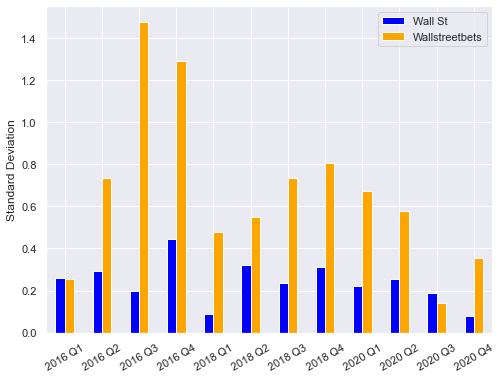

In [271]:
a=pd.DataFrame()
a['Wallst_STD'] = wallst['Standard Deviation']
a['WSBets_STD'] = WSBets['Standard Deviation']

a.plot(figsize=(8,6), kind = 'bar', color=('blue','orange'))
plt.legend(['Wall St', 'Wallstreetbets'])
plt.xticks(rotation=30)
plt.savefig('Risk comparison.png')
plt.ylabel("Standard Deviation")
print(a)


         Wallst_Sharpe  WSBets_Sharpe
2016 Q1       2.578466       3.660430
2016 Q2       2.896786       1.565895
2016 Q3       3.427857       1.187280
2016 Q4       2.149000       1.293867
2018 Q1       2.773802       2.119612
2018 Q2       1.975652       1.497220
2018 Q3       2.152696       1.413221
2018 Q4       2.002817       1.495695
2020 Q1       1.970035       1.284741
2020 Q2       1.907121       1.369644
2020 Q3       2.012967       2.062066
2020 Q4       3.509274       2.125852


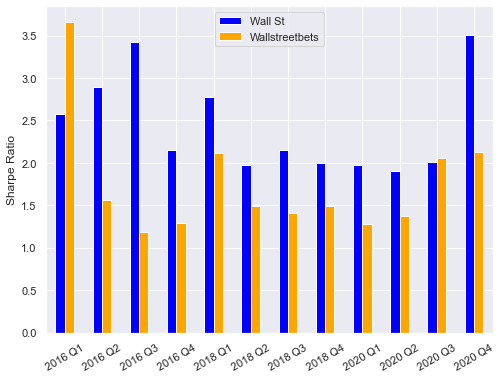

In [345]:
a=pd.DataFrame()
a['Wallst_Sharpe'] = wallst['Sharpe Ratio']
a['WSBets_Sharpe'] = WSBets['Sharpe Ratio']

a.plot(figsize=(8,6), kind = 'bar', color=('blue','orange'))
plt.legend(['Wall St', 'Wallstreetbets'])
plt.xticks(rotation=30)

plt.ylabel("Sharpe Ratio")
plt.savefig('Sharpe comparison.png')
print(a)

         Wallst_Sortino  WSBets_Sortino
2016 Q1        1.551345        2.577018
2016 Q2        2.043636        1.607569
2016 Q3        1.921867        2.051163
2016 Q4        2.316363        1.984875
2018 Q1        1.350263        2.784662
2018 Q2        1.802012        2.001799
2018 Q3        2.057244        2.303263
2018 Q4        2.266379        2.357098
2020 Q1        2.482380        1.098099
2020 Q2        2.666473        1.815788
2020 Q3        2.109292        1.943446
2020 Q4        1.763400        1.245796


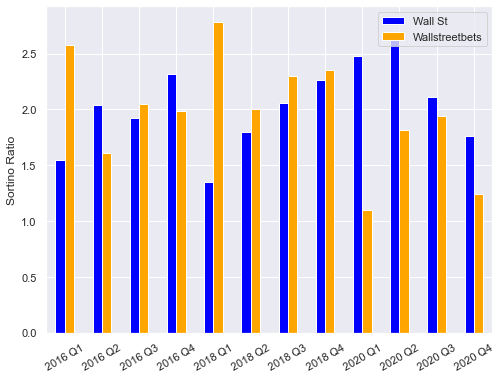

In [346]:
a=pd.DataFrame()
a['Wallst_Sortino'] = wallst['Sortino Ratio']
a['WSBets_Sortino'] = WSBets['Sortino Ratio']

a.plot(figsize=(8,6), kind = 'bar', color=('blue','orange'))
plt.legend(['Wall St', 'Wallstreetbets'])
plt.xticks(rotation=30)

plt.ylabel("Sortino Ratio")
plt.savefig('Sortino comparison.png')
print(a)

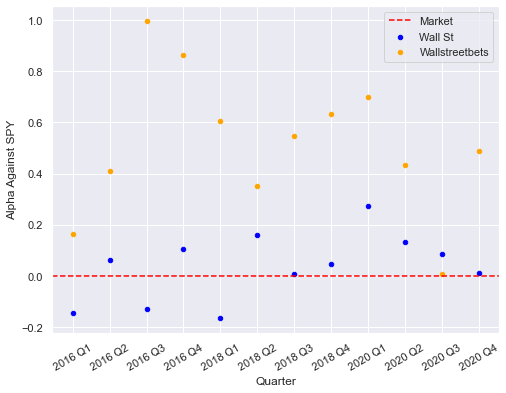

In [320]:
a=pd.DataFrame()
a['Wallst_alpha'] = wallst['Alpha against SPY']
a['WSBets_alpha'] = WSBets['Alpha against SPY']
a['Quarter']= wallst['Unnamed: 0']
   
sc = a.plot(figsize=(8,6),kind="scatter", x='Quarter',y="Wallst_alpha", color="b")
a.plot(kind="scatter", x="Quarter",y="WSBets_alpha", color="orange", ax=sc)

plt.xticks(rotation=30)
plt.ylabel("Alpha Against SPY")
# # adding horizontal line in data co-ordinates
plt.axhline(0, c='r', ls='--')
plt.legend(['Market','Wall St', 'Wallstreetbets'])
plt.savefig('Alpha against SPY.png')

#### End